# SLSTR plotting, quality control and data interrogation

This routine shows examples of how to use python netcdf libraries to ingest Level 2 SLSTR data, mask it according to quality control variables, correct for bias, select only for dual view data and compare it against other, coincident geo-physical variables.

    Version: 1.1
    Author: B loveday, PML
    Notes:
    1. A batch scripting version of the same file, where arguments can be passed from the 
       command line is also available.
    2. This routine has been designed to work with SLSTR L2 NRT data, which is available as 
       tiles. It can be easily adapted for application to L1 data, but care should be taken
       if using it to analyse L2 NTC data, as this is delivered as full orbit and not tiles.
      

In Python, we usually have a few sections of code at the top that occur before we enter the main programme. These
sections typically include:
1. importing modules
2. defining functions that are called in the main programme
3. defining arguments that are passed to the main programme (we can't do this when running in interactive mode e.g. ipython of jupyter notebook. We only really use this in batch mode)

Comment: We do not really require this next line, it is here only for consistency with the batch version. It tells batch python where python is so that (under linux and OSx) we can call the function as a direct executable.

In [1]:
#!/usr/bin/env python

Firstly, we begin by importing all of the external modules that we will be using in this script; they are annotated with brief explanations of what they do.

In [2]:
# import tools that allow us access tot system functions, e.g. get working directory, check path.
import os
import shutil

# import high level python system functions
import sys
import warnings

# import tools that let us manipulate dates and times
import datetime

# import tools that let us manipulate arrays (makes Python more like Matlab for matrix operations)
import numpy as np

# import tools that allow us to pass variables form external sources (not possible in jupyter or ipython)
import argparse

# import tools that facilitate string pattern matching
import fnmatch

# import tools that let us create log files to write to
import logging

# import tools for netCFD4 manipulation
from netCDF4 import Dataset

# import tools for plotting, making subplots, and utilising map projections
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.basemap import Basemap

# turn off warnings. Bad practice, but we don't want to see them here....
warnings.filterwarnings('ignore')

# turn off automatic plotting
plt.ioff()


Now we have imported all of our modules, we are going to define a quick function for later use. This function, called load_variables will read a variable form an open netCDF file, and make sure we have control of variable masking.

In [3]:
#-functions---------------------------------------------------------------------
def load_variables(nc_fid, varname, rem_mask=True, verbose=False):
    '''
     Quick function to load variables as numpy array, flatten and apply new mask based on fill value 
    '''
    if rem_mask:
        return_variable = nc_fid.variables[varname][:]
        if 'Masked' in str(type(return_variable)):
            try:
                return_fill     = nc_fid.variables[varname]._FillValue
                return_variable = return_variable.data
                return_variable[return_variable == return_fill] = np.nan
            except:
                if verbose:
                    print('No fill value')
    else:
        return_variable = nc_fid.variables[varname][:]
        
    if len(np.shape(return_variable)) == 3:
        return_variable = np.squeeze(return_variable)
    
    return return_variable

The next section is defines two paths for where we read our input data from (current working directory), and where we write our log files to (again, current working directory). 

In [4]:
#-default parameters------------------------------------------------------------
DEFAULT_ROOT_DIR    = os.getcwd()
DEFAULT_LOG_PATH    = os.getcwd()
DEFAULT_FILE_FILTER = '*SLSTR*.nc'

The following section is only relevant for batch mode, and controls how we read in arguments passed from externally. It is not relevant here, so it is commented out.

In [5]:
#-args--------------------------------------------------------------------------
#parser = argparse.ArgumentParser()
#parser.add_argument('-d', '--root_dir', type=str, default = DEFAULT_ROOT_DIR, help = 'Glider root directory')
#parser.add_argument('-l', '--log_path', type=str, default = DEFAULT_LOG_PATH,help = 'log file output path')
#parser.add_argument('-f', '--file_filter', type=str, default = DEFAULT_FILE_FILTER,help = 'default file filter')
#args = parser.parse_args()


#----------------------------------------------------PRE-AMBLE COMPLETE-----------------------------------------------

Right, after all of that preparation, we are at the main entrance point for our code. We begin by defining our logfile so we can record any errors here if things go wrong, or any info/debug messages we may want along the way if we don't want them printed to screen (or to the console in interactive mode).

In [6]:
#-main-------------------------------------------------------------------------
if __name__ == '__main__':    
    # preliminary stuff
    logfile = os.path.join(DEFAULT_LOG_PATH,"SLSTR_test_plot_"+datetime.datetime.now().strftime('%Y%m%d_%H%M')+".log")
    # we define a verbose flag to control how much info we want to see. It can also be useful to define a debug flag
    # for even more information.
    verbose=False
    no_show=True

We have defined a log file above, and here we set up how python will use it. Note that this is the first time we use the 'print' command. Print will output its contents to the screen, and here, this output will appear below the box when we run it.

In [7]:
    # set file logger
    try:
        if os.path.exists(logfile):
            os.remove(logfile)
        print("logging to: "+logfile)
        logging.basicConfig(filename=logfile,level=logging.DEBUG)
    except:
        print("Failed to set logger")

logging to: /shared/SLSTR/SLSTR_test_plot_20180409_1343.log


So, lets proceed with loading some SLSTR data. The first thing we need to do is find the relevant netCDF files that contain the data that we want to plot. This next block of code collects the names of all netCDF files in our DEFAULT_ROOT_DIR path. We can make this more specific by adapting the DEFAULT_FILE_FILTER variable from "*.nc".

We begin by setting up an empty "list" variables called nc_files, and append to this list as we proceed through a series of loops, defined by the "for" statements.

In [8]:
    # -get the files-------------------------------------------------------------
    nc_files=[]
    for root, _, filenames in os.walk(DEFAULT_ROOT_DIR):
        for filename in fnmatch.filter(filenames, DEFAULT_FILE_FILTER):
            nc_files.append(os.path.join(root, filename))
            if verbose:
                print('Found: '+filename)
            logging.info('Found: '+os.path.join(root, filename))

Lets check what files we have by looping through the list...

In python you can loop through the values in a list using "for item in list:"

In [9]:
    for nc_file in nc_files:
        print(nc_file)

/shared/SLSTR/SLSTR_test_data/MZC/S3A_SL_2_WST____20171202T193449_20171202T193749_20171202T205905_0179_025_127_5579_MAR_O_NR_002.SEN3/20171202193449-MAR-L2P_GHRSST-SSTskin-SLSTRA-20171202205905-v02.0-fv01.0.nc


Now lets loop through the ones we have found and start to look at our data.

In [10]:
    for nc_file in nc_files:
        if verbose:
            print(nc_file)

This next line opens our netCDF file. It does not read any data in yet, just makes the contents accessible. We should remember to close this link, especially if we are opening lots of files.

In [11]:
        nc_fid = Dataset(nc_file,'r')

We start by loading our coordinate variables, using the function that we defined at the top of the script. 

note: python is very accepting of white space, but the next line would flag as a problem in a code-checker like pylint. It is spaced like this to make it easy to read.

In [12]:
        LON           = load_variables(nc_fid,'lon')
        LAT           = load_variables(nc_fid,'lat')
        TIME          = load_variables(nc_fid,'adi_dtime_from_sst')

Now we load the quality and masking variables

In [13]:
        L2P_FLAGS     = load_variables(nc_fid,'l2p_flags')
        QUALITY_LEVEL = load_variables(nc_fid,'quality_level')

And finally we load our data variables and close the netCDF file link.

In [14]:
        SST_raw       = load_variables(nc_fid,'sea_surface_temperature',rem_mask = False)
        SST           = load_variables(nc_fid,'sea_surface_temperature')
        SST_STD_DEV   = load_variables(nc_fid,'sses_standard_deviation')
        SST_BIAS      = load_variables(nc_fid,'sses_bias')
        SST_ALG_TYPE  = load_variables(nc_fid,'sst_algorithm_type')
        WIND_SPEED    = load_variables(nc_fid,'wind_speed')
        nc_fid.close()

Now, lets set up our figure and make an initial plot of our SST data

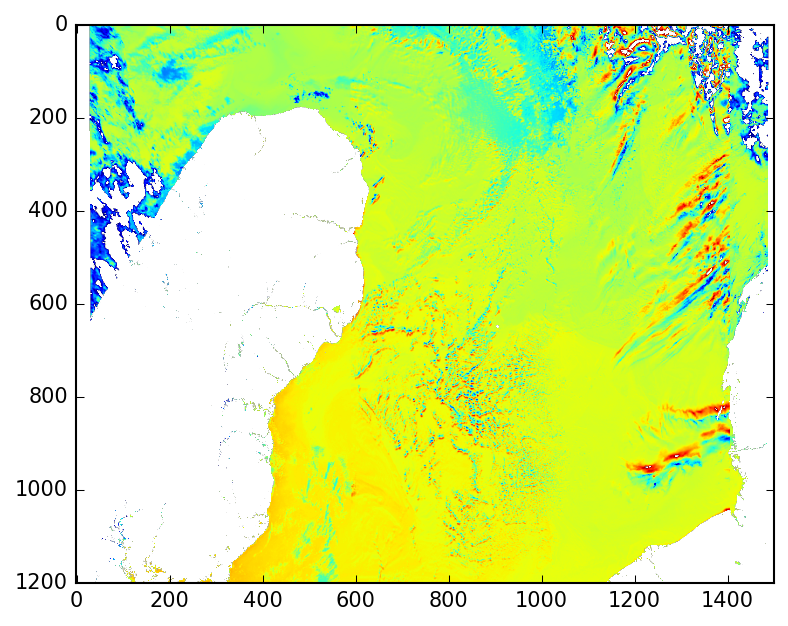

In [15]:
        fig  = plt.figure(figsize=(6,6), dpi=150)
        plt.imshow(SST)
        if no_show:
            fig.savefig('plot1.png',bbox_inches='tight')
        else:
            plt.show()

Plot successful, but this is ugly, not very helpful as it is not on any geographical map, incorrect as we have not taken abias into account, and has not been quality controlled! Lets take steps to improve this by:
1. reprojecting the data onto a map
2. make a contour plot against our LON and LAT data (we use contourf here as it is faster, but pcolor is more appropriate)
3. apply a more sensible colour bar for SST data
4. adding a colour bar

Then:
1. Masking our data for specific features and qulity values
2. Correcting our the SST for bias and considering the standard deviation
3. Considering dual SST only.

Lastly:
1. Checking associated variables; e.g. wind speed

So, lets perform the steps in the first list. The following code black does exactly that; reprojects (using the basemap toolkit), makes a filled contour plot (using contourf), applies a colour scale (cmap) and adds a colour bar (plt.colorbar).

In [16]:
        %%capture
        fig  = plt.figure(figsize=(10,10), dpi=300)
       
        # set projection
        lonmin = np.nanmin(LON)
        lonmax = np.nanmax(LON)
        latmin = np.nanmin(LAT)
        latmax = np.nanmax(LAT)
        m      = Basemap(llcrnrlon=lonmin,llcrnrlat=latmin,urcrnrlon=lonmax,urcrnrlat=latmax,resolution='i',projection='mill',lon_0=0.5*(lonmin+lonmax),lat_0=0.5*(latmin+latmax))
        x, y   = m(LON,LAT)    
    
        # set my vertical plotting order and fontsize
        zordcoast=0
        fsz=12
        SST_plot = SST.copy()
        vmin=np.nanmean(SST_plot)-3*np.nanstd(SST_plot)
        vmax=np.nanmean(SST_plot)+3*np.nanstd(SST_plot)
        SST_plot[SST_plot<vmin] = np.nan
        SST_plot[SST_plot>vmax] = np.nan

        # plot the data
        p1 = m.contourf(x,y,SST_plot,100,cmap=plt.cm.jet,vmin=vmin,vmax=vmax)
        
        # add embelishments
        m.fillcontinents(color=[0.4,0.4,0.4],zorder=zordcoast)
        m.drawcoastlines(color='k',linewidth=0.5, zorder=zordcoast+1)
        m.drawcountries(color='k', linewidth=0.25,zorder=zordcoast+2)
        m.drawparallels(np.arange(-90,  90,  5), labels=[1,0,0,0],fontsize=fsz,linewidth=0.1,zorder=zordcoast-0.1)
        m.drawmeridians(np.arange(-180, 180, 5), labels=[0,0,0,1],fontsize=fsz,linewidth=0.1,zorder=zordcoast-0.1)
            
        cbar = plt.colorbar(p1, orientation='horizontal')
        cbar.set_label('SST [K]',fontsize=fsz)


In [17]:
        if no_show:
            fig.savefig('plot2.png',bbox_inches='tight')
        else:
            plt.show()

A definite improvement, our data is now accompanied by a scale, with units, and is reprojected so we can relate it to a map.

However, we still have not interrogated our data. 

One of the most important things we need to do with SST data is consider the quality level - so lets start by doing that. 

The next code bloack will display the values of the quality level, stored in the quality level variables in the L2 WST product. Usually, we only consider the product viable where the quality flag is three or above.

In [18]:
        %%capture
        fig  = plt.figure(figsize=(20,20), dpi=300)
        gs  = gridspec.GridSpec(1, int(np.nanmax(QUALITY_LEVEL))+1)
        gs.update(wspace=0.01, hspace=0.01)

        contour_vals = np.arange(np.nanmin(QUALITY_LEVEL)-1,np.nanmax(QUALITY_LEVEL)+1,1)
        
        # loop through each algorithm
        for ii in np.arange(0,int(np.nanmax(QUALITY_LEVEL))+1):
            axes = plt.subplot(gs[0,ii])
            MASKED_QUALITY_LEVEL = QUALITY_LEVEL.astype('float')
            MASKED_QUALITY_LEVEL[MASKED_QUALITY_LEVEL != float(ii)] = np.nan
            # plot the data
            m.contourf(x,y,MASKED_QUALITY_LEVEL,cmap=plt.cm.jet)
            plt.text(0.1,0.1,ii,fontweight='bold',fontsize=fsz*2)
            # add embelishments
            m.fillcontinents(color=[0.4,0.4,0.4],zorder=zordcoast)
            m.drawcoastlines(color='k',linewidth=0.5, zorder=zordcoast+1)
            m.drawcountries(color='k', linewidth=0.25,zorder=zordcoast+2)

In [19]:
        if no_show:
            fig.savefig('plot3.png',bbox_inches='tight')
        else:
            plt.show()

So, lets mask out any data that have a quality value of 2 or lower...

In [20]:
SST[QUALITY_LEVEL<=2]=np.nan

Next, the SST field has two associated measurements that we need to consider, the bias, and the standard deviation. So lets plot these...

In [21]:
        %%capture
        fig  = plt.figure(figsize=(20,20), dpi=300)
        gs  = gridspec.GridSpec(1, 2)
         
        axes = plt.subplot(gs[0,0])
        
        # plot the data
        SST_plot = SST_BIAS.copy()
        vmin=np.nanmean(SST_plot)-3*np.nanstd(SST_plot)
        vmax=np.nanmean(SST_plot)+3*np.nanstd(SST_plot)
        SST_plot[SST_plot<vmin] = np.nan
        SST_plot[SST_plot>vmax] = np.nan
        
        p1 = m.contourf(x,y,SST_plot,100,cmap=plt.cm.jet,vmin=vmin,vmax=vmax)
        # add embelishments
        m.fillcontinents(color=[0.4,0.4,0.4],zorder=zordcoast)
        m.drawcoastlines(color='k',linewidth=0.5, zorder=zordcoast+1)
        m.drawcountries(color='k', linewidth=0.25,zorder=zordcoast+2)
        m.drawparallels(np.arange(-90,  90,  5), labels=[1,0,0,0],fontsize=fsz,linewidth=0.1,zorder=zordcoast-0.1)
        m.drawmeridians(np.arange(-180, 180, 5), labels=[0,0,0,1],fontsize=fsz,linewidth=0.1,zorder=zordcoast-0.1)
        
        cbar = plt.colorbar(p1, orientation='horizontal')
        cbar.set_label('SST bias [K]',fontsize=fsz)
        
        axes = plt.subplot(gs[0,1])
        # plot the data
        SST_plot = SST_STD_DEV.copy()
        vmin=np.nanmean(SST_plot)-3*np.nanstd(SST_plot)
        vmax=np.nanmean(SST_plot)+3*np.nanstd(SST_plot)
        SST_plot[SST_plot<vmin] = np.nan
        SST_plot[SST_plot>vmax] = np.nan
        
        p1 = m.contourf(x,y,SST_plot,100,cmap=plt.cm.jet,vmin=vmin,vmax=vmax)
        m.drawparallels(np.arange(-90,  90,  5), labels=[1,0,0,0],fontsize=fsz,linewidth=0.1,zorder=zordcoast-0.1)
        m.drawmeridians(np.arange(-180, 180, 5), labels=[0,0,0,1],fontsize=fsz,linewidth=0.1,zorder=zordcoast-0.1)       
        # add embelishments
        m.fillcontinents(color=[0.4,0.4,0.4],zorder=zordcoast)
        m.drawcoastlines(color='k',linewidth=0.5, zorder=zordcoast+1)
        m.drawcountries(color='k', linewidth=0.25,zorder=zordcoast+2)
        
        cbar = plt.colorbar(p1, orientation='horizontal')
        cbar.set_label('SST standard deviation [K]',fontsize=fsz)

In [22]:
        if no_show:
            fig.savefig('plot4.png',bbox_inches='tight')
        else:
            plt.show()

The SST value we are interested in needs to be corrected for the bias, so lets do that:

In [23]:
SST = SST + SST_BIAS

What do we do with Std Dev?

We can see from the bias and standard deviation plots that there are some sharp lines across the image. SLSTR uses 5 algorithms to estimate SST. Some of these algorithms use the nadir view only, while some take advantage of the 'Dual View' capability of the sensor. Dual view takes two images of the surface, one at nadir and one at an oblique angle. This allows it to better characterise the effects of the atmosphere. In practice, the nadir view is wider than the dual view, which results in a stripe along the middle of the swath. We can check which algorithms were used to derive the SST estimate by checking the SST_ALG_TYPE variable, as below:

In [24]:
        %%capture
        fig  = plt.figure(figsize=(20,20), dpi=300)
        gs  = gridspec.GridSpec(1, 6)
        gs.update(wspace=0.01, hspace=0.01)
        
        contour_vals = np.arange(np.nanmin(SST_ALG_TYPE)-1,np.nanmin(SST_ALG_TYPE)+1,1)
        
        # loop through each algorithm
        for ii in np.arange(0,int(np.nanmax(SST_ALG_TYPE))+1):
            axes = plt.subplot(gs[0,ii])
            MASKED_ALG_TYPE = SST_ALG_TYPE.astype('float')
            MASKED_ALG_TYPE[MASKED_ALG_TYPE != float(ii)] = np.nan
            # plot the data
            m.contourf(x,y,MASKED_ALG_TYPE,cmap=plt.cm.jet)
            if ii == 0:
                plt.text(0.1,0.1,'No retrieval',fontweight='bold',fontsize=fsz*2)
            elif ii >= 4:
                plt.text(0.1,0.1,'Dual',fontweight='bold',fontsize=fsz*2)
            else:
                plt.text(0.1,0.1,'Nadir',fontweight='bold',fontsize=fsz*2)

            # add embelishments
            m.fillcontinents(color=[0.4,0.4,0.4],zorder=zordcoast)
            m.drawcoastlines(color='k',linewidth=0.5, zorder=zordcoast+1)
            m.drawcountries(color='k', linewidth=0.25,zorder=zordcoast+2)

In [25]:
        if no_show:
            fig.savefig('plot5.png',bbox_inches='tight')
        else:
            plt.show()

We should remember that, just because a measurement is Nadir view only, it does not mean that it is bad! Sometimes the nadir view is the best to use. Here, though, lets finally plot our nadir+dual and our dual view data, corrected for bias, and masked for a quality level of 3 or greater. We will overlay the plot with contours from contemporaneous ECMWF wind data, that is included in with SLSTR L2 WAT products, as part of the GHRSST specification.

In [26]:
        %%capture
        SST_C = SST-273.15
        
        fig  = plt.figure(figsize=(15,20), dpi=150)
        gs  = gridspec.GridSpec(3, 1, height_ratios=[20,0.5,1])
        gs.update(wspace=0.01, hspace=0.01)
        
        # set projection
        lonmin = np.nanmin(LON[np.isfinite(SST_C)])
        lonmax = np.nanmax(LON[np.isfinite(SST_C)])
        latmin = np.nanmin(LAT[np.isfinite(SST_C)])
        latmax = np.nanmax(LAT[np.isfinite(SST_C)])
        m      = Basemap(llcrnrlon=lonmin,llcrnrlat=latmin,urcrnrlon=lonmax,urcrnrlat=latmax,resolution='h',projection='mill',lon_0=0.5*(lonmin+lonmax),lat_0=0.5*(latmin+latmax))
        x, y   = m(LON,LAT)    
    
        # set my vertical plotting order and fontsize
        zordcoast=0
        fsz=12

        # plot the data
        SST_plot = SST_C.copy()
        vmin=int(np.nanmean(SST_plot)-3*np.nanstd(SST_plot))-1
        vmax=int(np.nanmean(SST_plot)+3*np.nanstd(SST_plot))+1
        SST_plot[SST_plot<vmin] = np.nan
        SST_plot[SST_plot>vmax] = np.nan
        
        axes0 = plt.subplot(gs[0,0])
        p1 = m.contourf(x,y,SST_plot,100,cmap=plt.cm.jet,vmin=vmin,vmax=vmax,zorder=-1)
        CS = m.contour(x,y,WIND_SPEED,10,linewidths=1.0,cmap=plt.get_cmap('Greys'),zorder=0)
        plt.clabel(CS, fontsize=10, inline=1,zorder=1)

        # add embelishments
        m.fillcontinents(color=[0.4,0.4,0.4],zorder=zordcoast+10)
        m.drawcoastlines(color='k',linewidth=0.5, zorder=zordcoast+12)
        m.drawcountries(color='k', linewidth=0.25,zorder=zordcoast+13)
        m.drawparallels(np.arange(-90,  90,  5), labels=[1,0,0,0],fontsize=fsz,linewidth=0.1,zorder=zordcoast-0.1)
        m.drawmeridians(np.arange(-180, 180, 5), labels=[0,0,0,1],fontsize=fsz,linewidth=0.1,zorder=zordcoast-0.1)
            
        # add colorbar
        axes0 = plt.subplot(gs[2,0])
        cbar = plt.colorbar(p1, cax=axes0,orientation='horizontal')
        cbar.set_label('Bias corrected, quality controlled, whole view SST [$^{o}$C]',fontsize=fsz)


In [27]:
        bbox_inches='tight'
        fig.savefig(os.path.join(DEFAULT_ROOT_DIR,'SLSTR_whole_SST_demo.png'),bbox_inches='tight')

In [28]:
        %%capture
    
        SST_C = SST-273.15
        SST_C[SST_ALG_TYPE<4] = np.nan

        fig  = plt.figure(figsize=(15,20), dpi=150)
        gs  = gridspec.GridSpec(3, 1, height_ratios=[20,0.5,1])
        gs.update(wspace=0.01, hspace=0.01)
        
        # set projection
        lonmin = np.nanmin(LON[np.isfinite(SST_C)])
        lonmax = np.nanmax(LON[np.isfinite(SST_C)])
        latmin = np.nanmin(LAT[np.isfinite(SST_C)])
        latmax = np.nanmax(LAT[np.isfinite(SST_C)])
        m      = Basemap(llcrnrlon=lonmin,llcrnrlat=latmin,urcrnrlon=lonmax,urcrnrlat=latmax,resolution='h',projection='mill',lon_0=0.5*(lonmin+lonmax),lat_0=0.5*(latmin+latmax))
        x, y   = m(LON,LAT)    
    
        # set my vertical plotting order and fontsize
        zordcoast=0
        fsz=12

        # plot the data
        SST_plot = SST_C.copy()
        vmin=int(np.nanmean(SST_plot)-3*np.nanstd(SST_plot))-1
        vmax=int(np.nanmean(SST_plot)+3*np.nanstd(SST_plot))+1
        SST_plot[SST_plot<vmin] = np.nan
        SST_plot[SST_plot>vmax] = np.nan
        
        axes0 = plt.subplot(gs[0,0])
        p1 = m.contourf(x,y,SST_plot,100,cmap=plt.cm.jet,vmin=vmin,vmax=vmax,zorder=-1)
        CS = m.contour(x,y,WIND_SPEED,10,linewidths=1.0,cmap=plt.get_cmap('Greys'),zorder=0)
        plt.clabel(CS, fontsize=10, inline=1,zorder=1)

        # add embelishments
        m.fillcontinents(color=[0.4,0.4,0.4],zorder=zordcoast+10)
        m.drawcoastlines(color='k',linewidth=0.5, zorder=zordcoast+12)
        m.drawcountries(color='k', linewidth=0.25,zorder=zordcoast+13)
        m.drawparallels(np.arange(-90,  90,  5), labels=[1,0,0,0],fontsize=fsz,linewidth=0.1,zorder=zordcoast-0.1)
        m.drawmeridians(np.arange(-180, 180, 5), labels=[0,0,0,1],fontsize=fsz,linewidth=0.1,zorder=zordcoast-0.1)
            
        # add colorbar
        axes0 = plt.subplot(gs[2,0])
        cbar = plt.colorbar(p1, cax=axes0,orientation='horizontal')
        cbar.set_label('Bias corrected, quality controlled, dual view SST [$^{o}$C]',fontsize=fsz)

In [29]:
        bbox_inches='tight'
        fig.savefig(os.path.join(DEFAULT_ROOT_DIR,'SLSTR_dual_SST_demo.png'),bbox_inches='tight')